In [1]:
%run modules.ipynb
# Change this cell to change the kernel function throughout

# import multiprocessing
# from multiprocessing import Pool
# from time import sleep

In [2]:
"""The file has been created in zip format, reading it"""

zf = zipfile.ZipFile('./MP_db.zip') 
df_csv = pd.read_csv(zf.open('MP_db.csv'), usecols=['e_hull','gap pbe', 'mu_b','structure', 'elastic anisotropy','bulk modulus', 'shear modulus', 'e_form'])

formE=df_csv['e_form']
len(formE)

7676

In [3]:
init=2000
stop=4500
ase_fra=ase.io.read('MP_red.xyz', index=str(init)+':'+str(stop))
len(ase_fra)

2500

In [4]:
formE=list(formE[init:stop])

l=np.concatenate(ase_fra)
Y=np.zeros((len(l), 1))

natoms_list=[]

for frame in ase_fra:
    natoms=(len(frame))
    natoms_list.append(natoms)
   
start=0
for i in range(len(formE)):
    natoms=natoms_list[i]
    Y[start:int(start+natoms)] = formE[i]/natoms_list[i]
    start=start+natoms
print("Y shape is:"+ str(Y.shape))
Y


Y shape is:(14674, 1)


array([[-0.19929829],
       [-0.19929829],
       [-0.19929829],
       ...,
       [-0.24941386],
       [-0.24941386],
       [-0.24941386]])

In [5]:
# %whos 
select=200
frames_ase=[]

for frame in ase_fra:
    frame.wrap(eps=1e-12)
    frames_ase.append(frame)
#LANDMARK SET
frames_ase_random=random.sample(frames_ase, select)

n_FPS=50
soap = SOAP(soap_type='PowerSpectrum',
           interaction_cutoff=3.5,
           max_radial=5,
           max_angular=5,
           gaussian_sigma_type='Constant',
           gaussian_sigma_constant=0.4,
           cutoff_smooth_width=0.5, 
           normalize=False)
soap_rep= soap.transform(frames_ase_random)
soap_rep

In [6]:
# %whos 

Xsparse = soap_rep.get_features(soap)
col_idxs = FPS(n_features_to_select=n_FPS).fit(Xsparse).selected_idx_
Xsparse = Xsparse[:, col_idxs]
Xsparse.shape, max(col_idxs)

# for obj in locals().values():
#     print (sys.getsizeof(obj)) 
# import sys

# local_vars = list(locals().items())
# for var, obj in local_vars:
#     print(var, sys.getsizeof(obj))

((1149, 50), 59208)

In [17]:
Xsparse_tot=[]

step=100
for i in range(0, len(ase_fra), step):
    soap_rep= soap.transform(frames_ase[i:i+step])
    Xsp = soap_rep.get_features(soap)
#     print(Xsp.shape)
    z=[ [0] * (max(col_idxs)-len(Xsp[0])+1) for _ in range(len(Xsp))]
    z=np.asarray(z)
    Xsp=np.append(Xsp, z, axis=1)
#     print(Xsp.shape)
    Xsp = Xsp[:, col_idxs]
    print(Xsp.shape)
    Xsparse_tot.append(Xsp)
    
Xrest=np.concatenate(Xsparse_tot)
Xrest.shape

(400, 50)
(408, 50)
(400, 50)
(400, 50)
(400, 50)
(445, 50)
(500, 50)
(500, 50)
(500, 50)
(500, 50)
(568, 50)
(600, 50)
(600, 50)
(606, 50)
(600, 50)
(600, 50)
(600, 50)
(638, 50)
(707, 50)
(702, 50)
(800, 50)
(800, 50)
(800, 50)
(800, 50)
(800, 50)


(14674, 50)

In [18]:
%%time
Y_c=np.copy(Y)
Xrest_c=np.copy(Xrest)
Y_c.shape, Xrest_c.shape, Y, Xrest_c

CPU times: user 223 µs, sys: 4.11 ms, total: 4.33 ms
Wall time: 2.63 ms


((14674, 1),
 (14674, 50),
 array([[-0.19929829],
        [-0.19929829],
        [-0.19929829],
        ...,
        [-0.24941386],
        [-0.24941386],
        [-0.24941386]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

In [19]:
# Splits in train and test sets
X=Xrest_c
n_train = int(len(Y)/2)
n_test = len(Y)-n_train
r_train = np.asarray(range(len(Y)))
i_train, i_test = train_test_split(r_train, train_size=n_train, shuffle=True)
Y=Y_c
X_train = X[i_train]
Y_train = Y[i_train]
X_test = X[i_test]
Y_test = Y[i_test]

print(f'Shape of testing data is: {X_train.shape}, ||X|| = {np.linalg.norm(X_train)}.')
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

Shape of testing data is: (7337, 50), ||X|| = 0.02486017838233125.
(7337, 50) (7337, 50) (7337, 1) (7337, 1)


In [20]:
if X_test.shape!=X_train.shape:
    X_test=X_test[:-1,:]
    Y_test=Y_test[:-1,:]
    
if X_test.shape!=X_train.shape and X_test.shape<X_train.shape:
    X_train=X_train[:-1,:]
    Y_train=Y_train[:-1,:]  

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)  


(7337, 50) (7337, 50) (7337, 1) (7337, 1)


In [21]:
x_scaler = StandardFlexibleScaler(column_wise=False).fit(X_train)
y_scaler = StandardFlexibleScaler(column_wise=True).fit(Y_train)

# Center total dataset
X = x_scaler.transform(X)
Y = y_scaler.transform(Y)

# Center training data
X_train = x_scaler.transform(X_train)
Y_train = y_scaler.transform(Y_train)

# Center training data
X_test = x_scaler.transform(X_test)
Y_test = y_scaler.transform(Y_test)

In [22]:
kernel_params = {"kernel": "rbf", "gamma": 1}
kernel_func = partial(rbf_kernel, gamma=1)
kernel_type = "gaussian"

K_train = gaussian_kernel(X_train, X_train)
K_test = gaussian_kernel(X_test, X_train)

k_scaler = KernelNormalizer().fit(K_train)

K_train = k_scaler.transform(K_train)
K_test = k_scaler.transform(K_test)

1e-06


<AxesSubplot:title={'center':'KPCovR'}, xlabel='$Y$', ylabel='$\\hat{Y}$'>

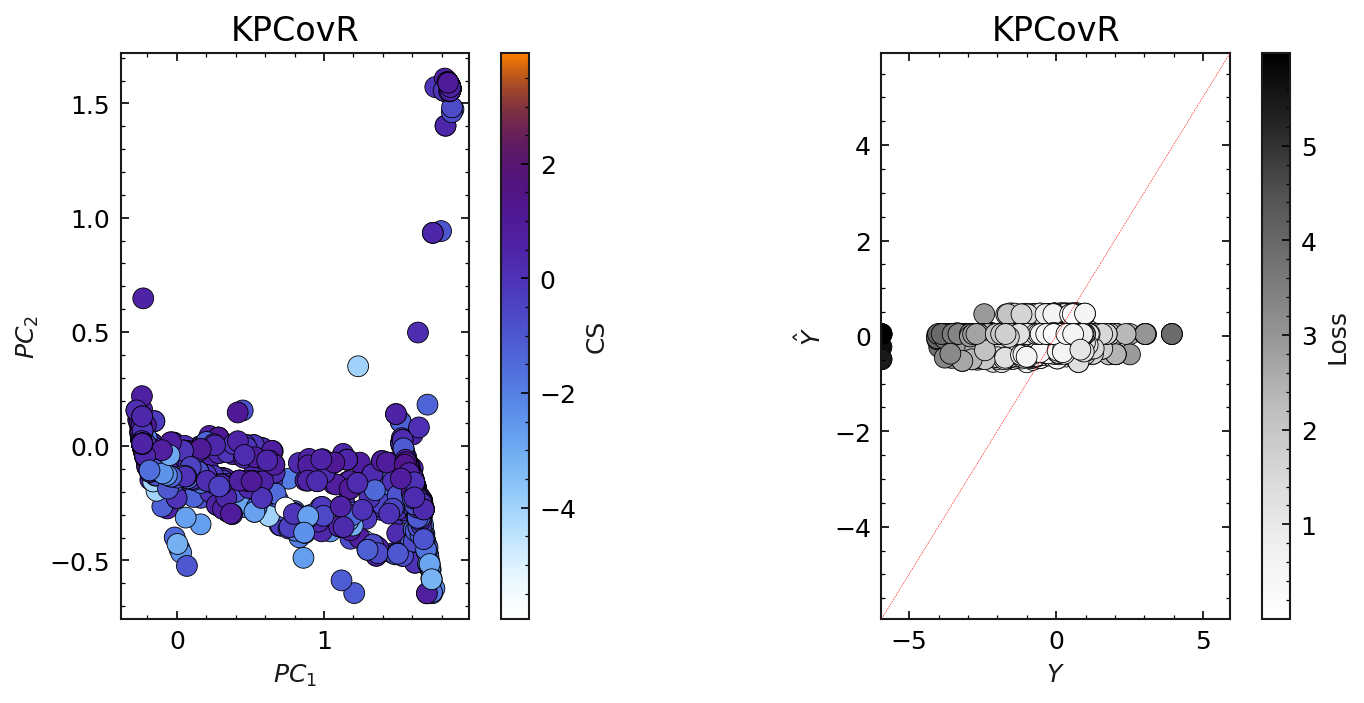

In [29]:
alpha=0.5

kp = KPCovR(mixing=alpha, n_components=2, **kernel_params, center=True)
kp.fit(X_train, Y_train)
print(kp.alpha)
t = kp.transform(X_test)
y = kp.predict(X_test)
fig, ax = plt.subplots(1, 2, figsize=dbl_fig)

plot_projection(Y_test, t, title="KPCovR", fig=fig, ax=ax[0], **cmaps)
plot_regression(Y_test[:, 0], y[:, 0], title="KPCovR", fig=fig, ax=ax[1], **cmaps)

In [30]:
regularization = 1e-2

krr = KernelRidge(alpha=regularization, **kernel_params)

krr.fit(K_train, Y_train)

Y_krr_train = krr.predict(K_train)
Y_krr_test = krr.predict(K_test)

table_from_dict([get_stats(x=X_train, yp=Y_krr_train,y=Y_train, k=K_train), 
                 get_stats(x=X_test,  yp=Y_krr_test, y=Y_test, k=K_test)], 
                 headers = ["Training", "Testing"], 
                 title="Kernel Ridge Regression")

<center><b> Kernel Ridge Regression </b></center><br>                            <center><table><tr><th></th><th><center>Training</center></th><th><center>Testing</center></th></tr><td> Coefficient of Determination<br>($R^2$) </td>                                                <td> 0.242958 </td><td> 0.102015 </td></tr><tr><td> $\ell_{regr}$ </td>                                                <td> 0.0101578 </td><td> 0.0110014 </td></tr></table></center>

T_train shape is(7337, 2), T_test shape is(7337, 2)


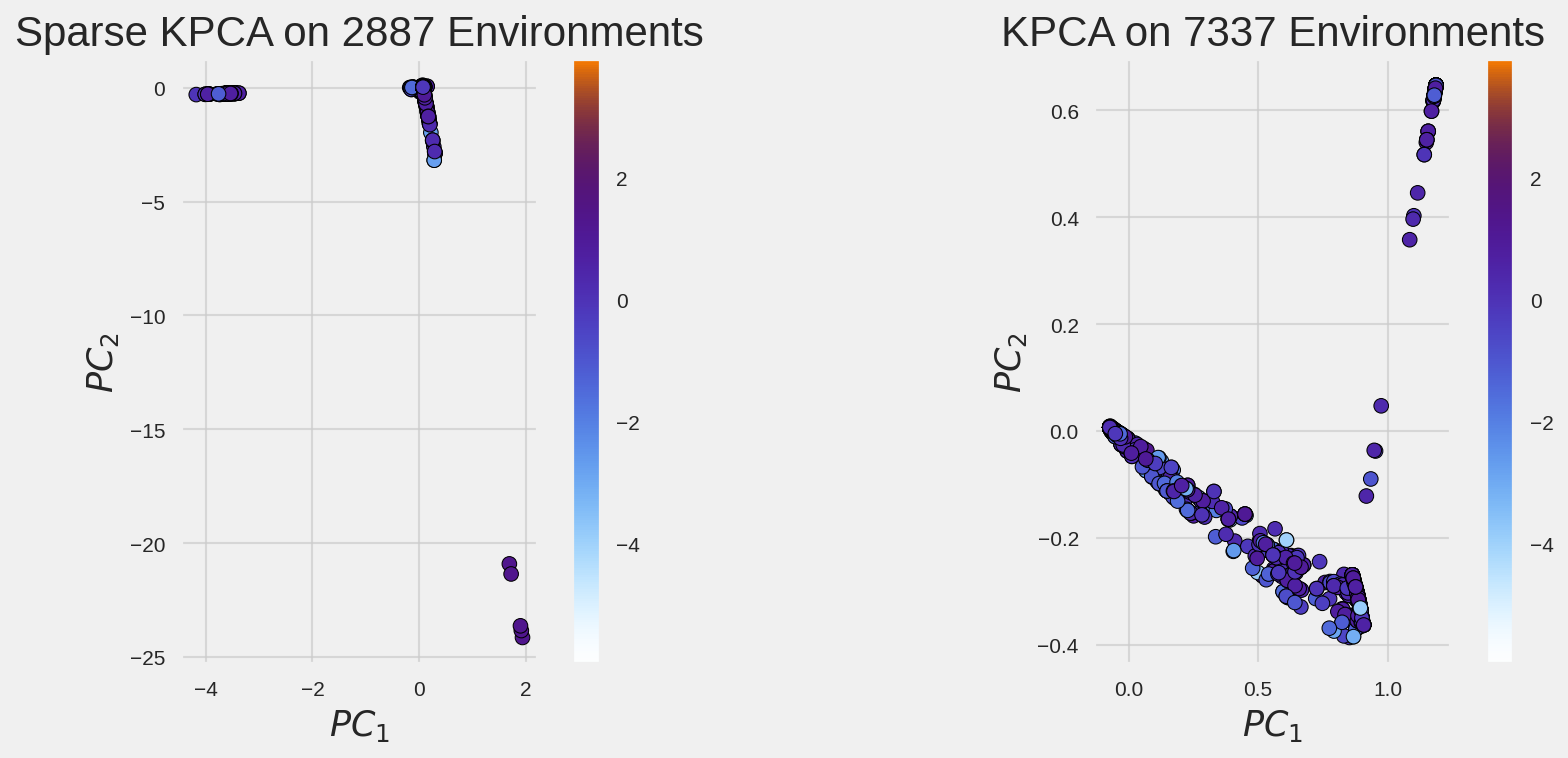

In [26]:
K_center = np.mean(Knm_train, axis=0)

Knm_train -= K_center
Knm_test -= K_center

K_scale = Knm_train @ np.linalg.pinv(Kmm, rcond=1.0E-12) @ Knm_train.T
K_scale = np.sqrt(np.trace(K_scale) / Knm_train.shape[0])

Knm_train /= K_scale
Knm_test /= K_scale


n_active=51

vmm, Umm = np.linalg.eigh(Kmm)

# Umm/vmm are already sorted, but in *increasing* order, so reverse them
Umm = np.flip(Umm, axis=1)
vmm = np.flip(vmm, axis=0)

Umm = Umm[:, vmm > 0]
vmm = vmm[vmm > 0]

Phi = (
    Knm_train
    @ Umm[:, : n_active - 1]
    @ np.diagflat(1.0 / np.sqrt(vmm[0 : n_active - 1]))
)


C = np.dot(Phi.T, Phi)

v_C, U_C = np.linalg.eigh(C)

# U_C/v_C are already sorted, but in *increasing* order, so reverse them
U_C = np.flip(U_C, axis=1)
v_C = np.flip(v_C, axis=0)

U_C = U_C[:, v_C > 0]
v_C = v_C[v_C > 0]


x_scaler = StandardFlexibleScaler(column_wise=False).fit(X_train)
y_scaler = StandardFlexibleScaler(column_wise=False).fit(Y_train)

X = x_scaler.transform(X)
X_train = x_scaler.transform(X_train)
X_test = x_scaler.transform(X_test)

Y = y_scaler.transform(Y)
Y_train = y_scaler.transform(Y_train)
Y_test = y_scaler.transform(Y_test)



n_PC=2


PKT = (
    Umm[:, : n_active - 1]
    @ np.diagflat(1.0 / np.sqrt(vmm[0 : n_active - 1]))
    @ U_C[:, :n_PC]
)

T_train = Knm_train @ PKT
T_test = Knm_test @ PKT


print("T_train shape is"+str(T_train.shape)+", T_test shape is"+str(T_test.shape))

ref_kpca = KernelPCA(
    n_components=n_PC, kernel="rbf", gamma=1.0, fit_inverse_transform=True
)
ref_kpca.fit(X_train)
T_kpca = ref_kpca.transform(X_test)
T_kpca_tot=ref_kpca.transform(X)
fig, axes = plt.subplots(1, 2, figsize=dbl_fig)
plot_projection(
    Y_test,
    check_mirrors(T_test, T_kpca),
    fig=fig,
    ax=axes[0],
    title="Sparse KPCA on {} Environments".format(Kmm.shape[0]),
    **cmaps
)

plot_projection(
    Y_test,
    T_kpca,
    fig=fig,
    ax=axes[1],
    title="KPCA on {} Environments".format(X_train.shape[0]),
    **cmaps
)

fig.subplots_adjust(wspace=0.4)


In [27]:
T=np.concatenate((T_train, T_test), axis=0)
T_test.shape, T_train.shape, Y.shape, T.shape, T_kpca_tot.shape

((7337, 2), (7337, 2), (14674, 1), (14674, 2), (14674, 2))

Training scores:

 [[-0.54543022 -0.10162863 -0.10162863 -0.10162863 -0.10162863]
 [-1.56504341 -0.10596091 -0.10596091 -0.10596091 -0.10596091]
 [-1.11116076 -0.18340207 -0.18340207 -0.18340207 -0.18340207]
 [-1.2553309  -0.25248756 -0.25248756 -0.25248756 -0.25248756]
 [-1.49199014 -0.21554677 -0.21554677 -0.21554677 -0.21554677]
 [-1.48531885 -0.19846032 -0.19846032 -0.19846032 -0.19846032]
 [-1.34522532 -0.194458   -0.194458   -0.194458   -0.194458  ]
 [-1.36998694 -0.18628705 -0.18628705 -0.18628705 -0.18628705]
 [-1.23764065 -0.18987686 -0.18987686 -0.18987686 -0.18987686]
 [-1.28350474 -0.19119772 -0.19119772 -0.19119772 -0.19119772]
 [-1.28683216 -0.1841373  -0.1841373  -0.1841373  -0.1841373 ]
 [-1.31206606 -0.18662075 -0.18662075 -0.18662075 -0.18662075]
 [-1.40019398 -0.46075935 -0.46075935 -0.46075935 -0.46075935]
 [-1.41701838 -0.45085372 -0.45085372 -0.45085372 -0.45085372]
 [-1.38048419 -0.49003012 -0.49003012 -0.49003012 -0.49003012]
 [-1.48212956 -0.52402453 -0.5240245

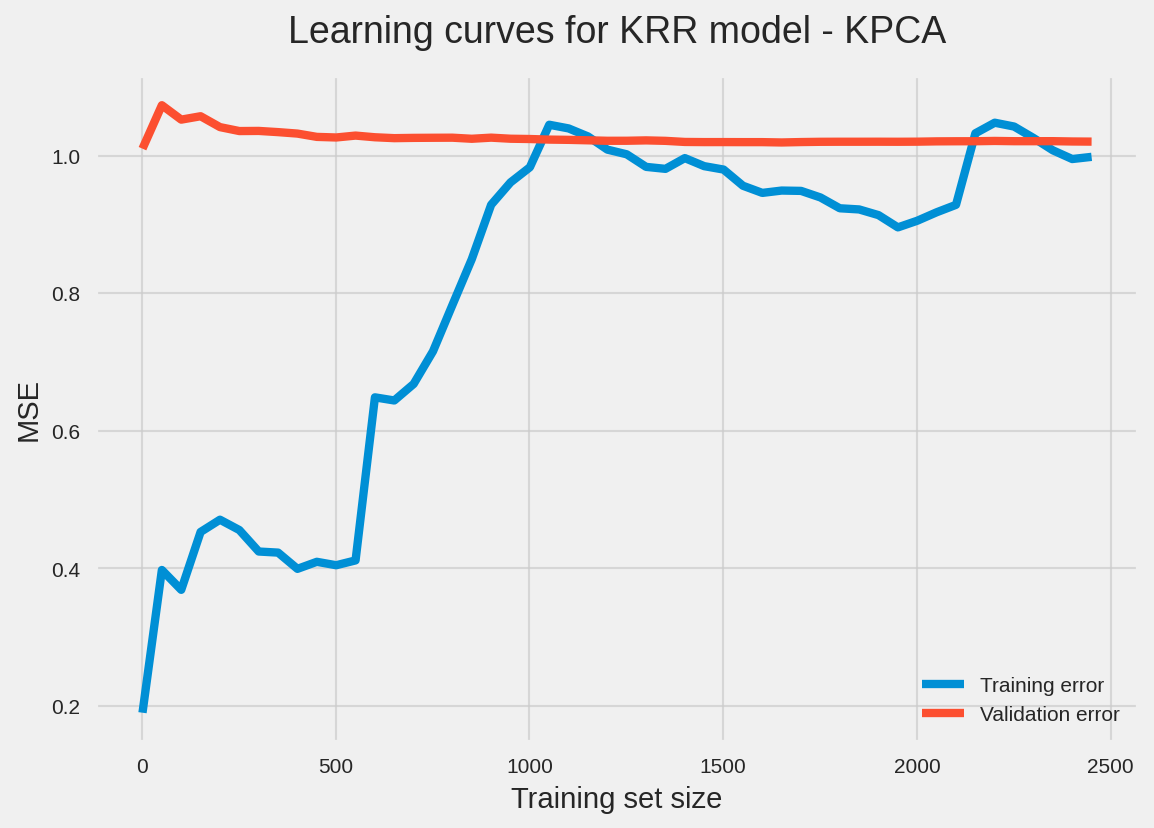

Training scores:

 [[-0.54536825 -0.10161709 -0.10161709 -0.10161709 -0.10161709]
 [-2.74829166 -0.10579285 -0.10579285 -0.10579285 -0.10579285]
 [-2.50432145 -0.17069605 -0.17069605 -0.17069605 -0.17069605]
 [-2.76515267 -0.2462125  -0.2462125  -0.2462125  -0.2462125 ]
 [-2.45938489 -0.21440188 -0.21440188 -0.21440188 -0.21440188]
 [-2.1959361  -0.20138568 -0.20138568 -0.20138568 -0.20138568]
 [-2.08984414 -0.20021622 -0.20021622 -0.20021622 -0.20021622]
 [-2.0977785  -0.19246618 -0.19246618 -0.19246618 -0.19246618]
 [-1.86514337 -0.19628332 -0.19628332 -0.19628332 -0.19628332]
 [-1.78512237 -0.19700272 -0.19700272 -0.19700272 -0.19700272]
 [-1.75780016 -0.18868329 -0.18868329 -0.18868329 -0.18868329]
 [-1.77771346 -0.19014538 -0.19014538 -0.19014538 -0.19014538]
 [-1.79355061 -0.46350642 -0.46350642 -0.46350642 -0.46350642]
 [-1.76617875 -0.45346154 -0.45346154 -0.45346154 -0.45346154]
 [-1.70348999 -0.49195921 -0.49195921 -0.49195921 -0.49195921]
 [-1.7885617  -0.52727723 -0.5272772

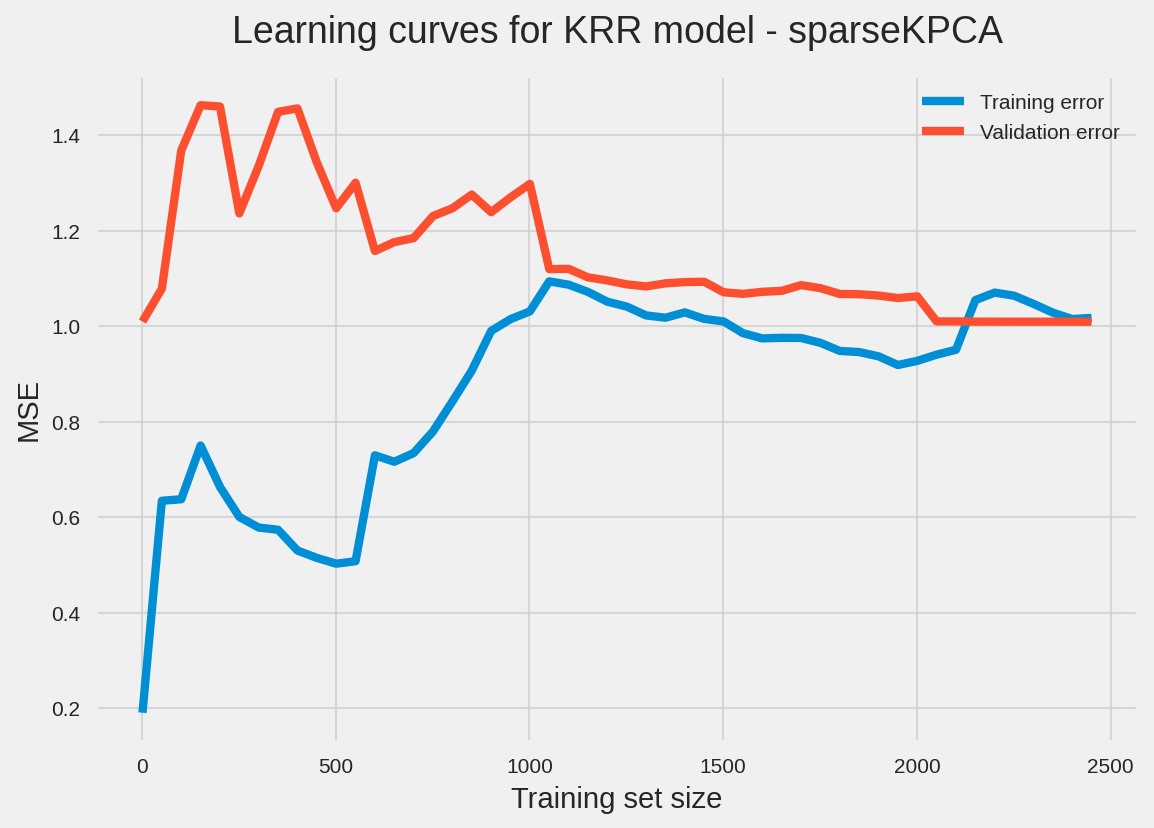

In [28]:
train_sizes = np.arange(1, len(ase_fra), 50).tolist()



train_sizes, train_scores, validation_scores = learning_curve(estimator = KernelRidge(), X=T_kpca_tot, y=Y, 

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis =1 )

plt.style.use('fivethirtyeight')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for KRR model - KPCA', fontsize = 18, y = 1.03)
plt.legend()
plt.show()
plt.close()


train_sizes, train_scores, validation_scores = learning_curve(estimator = KernelRidge(), X=T, y=Y, 
 
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis =1 )

plt.style.use('fivethirtyeight')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for KRR model - sparseKPCA', fontsize = 18, y = 1.03)
plt.legend()
plt.show()
plt.close()


In [29]:
PTX = np.diagflat(1.0 / (v_C[:n_PC])) @ T_train.T @ X_train

Xr_test = T_test @ PTX

In [30]:
K_approx_train = T_train @ T_train.T

K_test_test = kernel_func(X_test, X_test)
K_approx_test = T_test @ T_test.T

table_from_dict(
    [
        get_stats(
            x=X_test,
            xr=ref_kpca.inverse_transform(T_kpca),
            y=Y_test,
            t=T_kpca,
            k=K_test,
            kapprox=T_kpca @ T_kpca.T,
        ),
        get_stats(
            x=X_test,
            xr=Xr_test,
            y=Y_test,
            t=T_test,
            k=K_test_test,
            kapprox=K_approx_test,
        ),
    ],
    headers=["KPCA", "sKPCA"],
    title="sKPCA",
)

<center><b> sKPCA </b></center><br>                            <center><table><tr><th></th><th><center>KPCA</center></th><th><center>sKPCA</center></th></tr><td> Dataset Variance<br>$\sigma_X^2$ </td>                                                <td> 1.17235 </td><td> 1.17235 </td></tr><tr><td> Projection Variance<br>$\sigma_T^2$ </td>                                                <td> 0.0726641 </td><td> 0.587236 </td></tr><tr><td> Residual Variance<br>$\sigma_X^2 - \sigma_T^2$ </td>                                                <td> 1.09969 </td><td> 0.585117 </td></tr><tr><td> $\ell_{proj}$ </td>                                                <td> 1.58394 </td><td> 0.585212 </td></tr><tr><td> $\ell_{gram}$ </td>                                                <td> 4.01247e+12 </td><td> 1.20085 </td></tr></table></center>

CPU times: user 3 µs, sys: 5 µs, total: 8 µs
Wall time: 27.2 µs


<center><b> Ridge Regression </b></center><br>                            <center><table><tr><th></th><th><center>KRR</center></th><th><center>sKRR</center></th></tr><td> Coefficient of Determination<br>($R^2$) </td>                                                <td> -0.000224703 </td><td> 0.0279592 </td></tr><tr><td> $\ell_{regr}$ </td>                                                <td> 0.0117823 </td><td> 0.0116151 </td></tr></table></center>

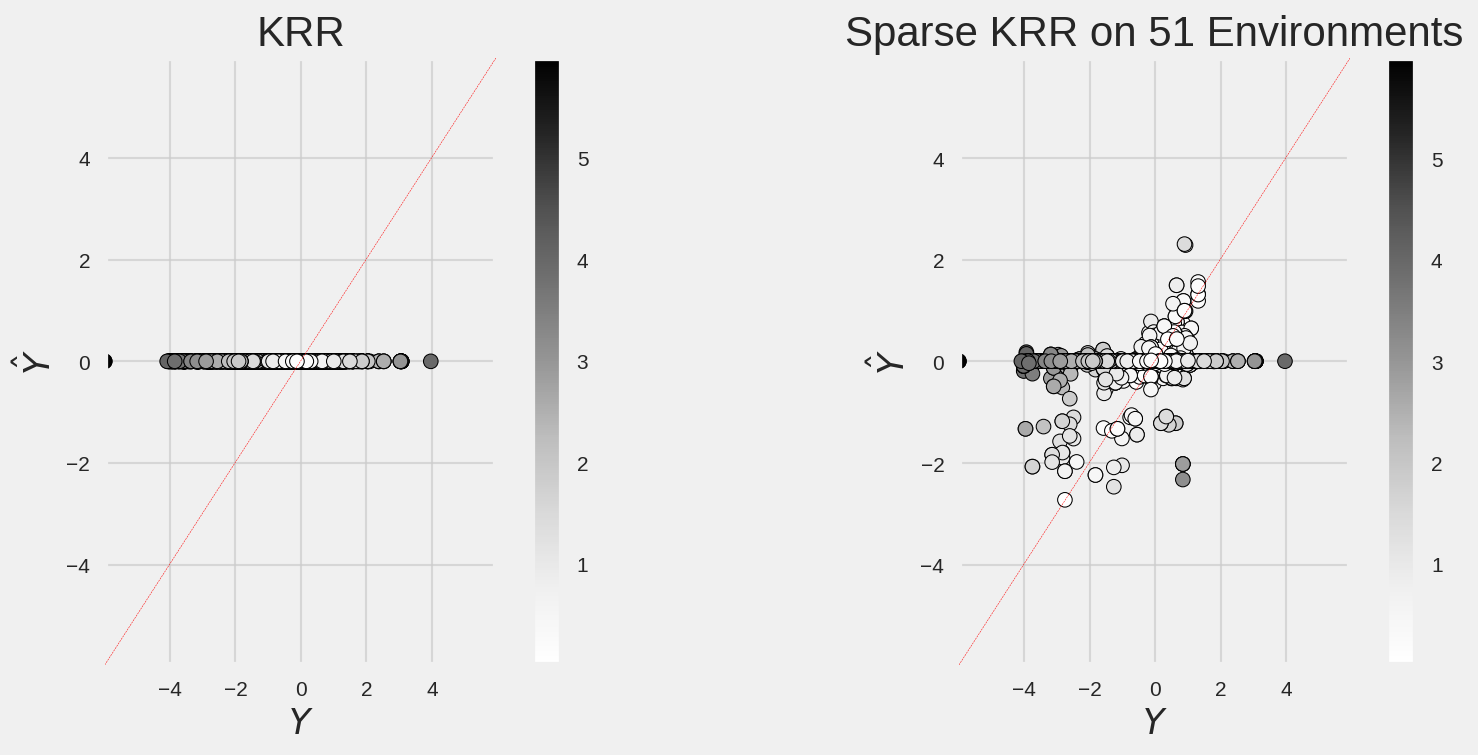

In [33]:
regularization = 0.9
%time

PKY = Knm_train.T @ Knm_train + regularization * Kmm
PKY = np.linalg.pinv(PKY)
PKY = PKY @ Knm_train.T @ Y_train

Y_skrr_train = Knm_train @ PKY
Y_skrr_test = Knm_test @ PKY

fig, axes = plt.subplots(1, 2, figsize=dbl_fig)

ref_krr = KernelRidge(alpha=regularization, **kernel_params)
ref_krr.fit(X=K_train, y=Y_train)
Y_krr = ref_krr.predict(X=K_test)

plot_regression(Y_test[:, 0], Y_krr[:, 0], title="KRR", fig=fig, ax=axes[0], **cmaps)
plot_regression(
    Y_test[:, 0],
    Y_skrr_test[:, 0],
    title="Sparse KRR on {} Environments".format(n_active),
    fig=fig,
    ax=axes[1],
    **cmaps
)

table_from_dict(
    [
        get_stats(
            x=X_test,
            y=Y_test,
            yp=Y_krr,
        ),
        get_stats(
            x=X_test,
            y=Y_test,
            yp=Y_skrr_test,
        ),
    ],
    headers=["KRR", "sKRR"],
    title="Ridge Regression",
)



In [34]:
C = np.dot(Phi.T, Phi)

v_C, U_C = np.linalg.eigh(C)

# U_C/v_C are already sorted, but in *increasing* order, so reverse them
U_C = np.flip(U_C, axis=1)
v_C = np.flip(v_C, axis=0)

U_C = U_C[:, v_C > 0]
v_C = v_C[v_C > 0]
alpha = 0.5
regularization = 1e-6

Csqrt = U_C @ np.diagflat(np.sqrt(v_C)) @ U_C.T
iCsqrt = U_C @ np.diagflat(1.0 / np.sqrt(v_C)) @ U_C.T

C_pca = C / (np.trace(C) / C.shape[0])

C_lr = np.linalg.pinv(C + regularization * np.eye(C.shape[0]))
C_lr = iCsqrt @ Phi.T @ Phi @ C_lr @ Phi.T @ Y_train.reshape(-1, Y_train.shape[-1])
C_lr = C_lr @ C_lr.T

Ct = alpha * C_pca + (1 - alpha) * C_lr
v_Ct, U_Ct = np.linalg.eigh(Ct)

# U_Ct/v_Ct are already sorted, but in *increasing* order, so reverse them
U_Ct = np.flip(U_Ct, axis=1)
v_Ct = np.flip(v_Ct, axis=0)

U_Ct = U_Ct[:, v_Ct > 0]
v_Ct = v_Ct[v_Ct > 0]

PPT = iCsqrt @ U_Ct[:, :n_PC] @ np.diag(np.sqrt(v_Ct[:n_PC]))
v_Ct.shape

(36,)

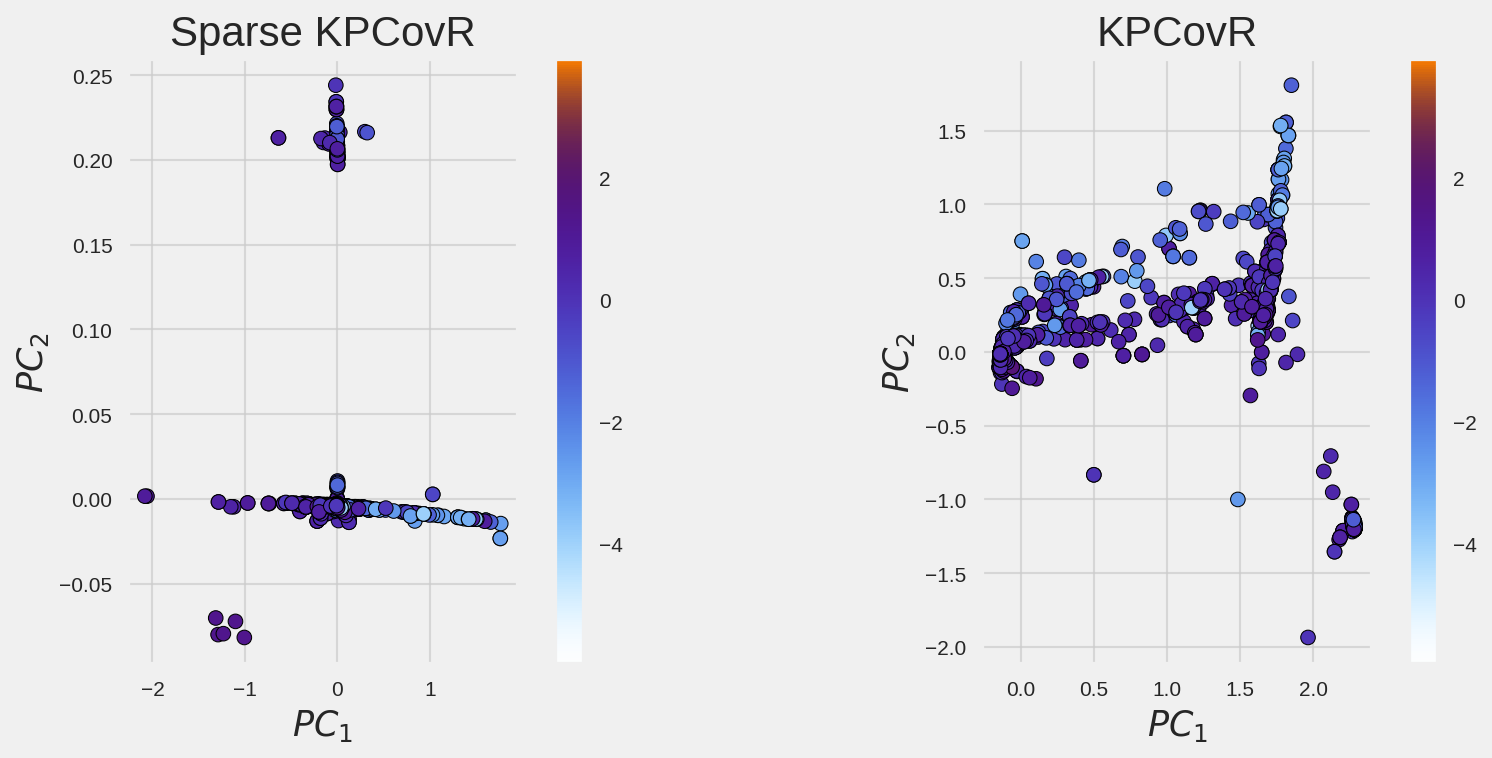

In [35]:
PKT = Umm[:, :n_active-1] @ np.diagflat(1/np.sqrt(vmm[:n_active-1])) @ PPT
T =  Knm_train @ PKT
T_skpcovr_test = Knm_test @ PKT

ref = KPCovR(mixing=alpha, n_components=2, center=True, **kernel_params)
ref.fit(X_train, Y_train)


t = ref.transform(X_test)


y = ref.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=dbl_fig)

plot_projection(
    Y_test,
    check_mirrors(T_skpcovr_test, t),
    fig=fig,
    ax=axes[0],
    title="Sparse KPCovR",
    **cmaps
)
plot_projection(Y_test, t, fig=fig, ax=axes[1], title="KPCovR", **cmaps)

plt.show()


In [39]:
T.shape, T_skpcovr_test.shape

T_skpcovr=np.concatenate((T, T_skpcovr_test), axis=0)

T_skpcovr.shape

t_tot = ref.transform(X)

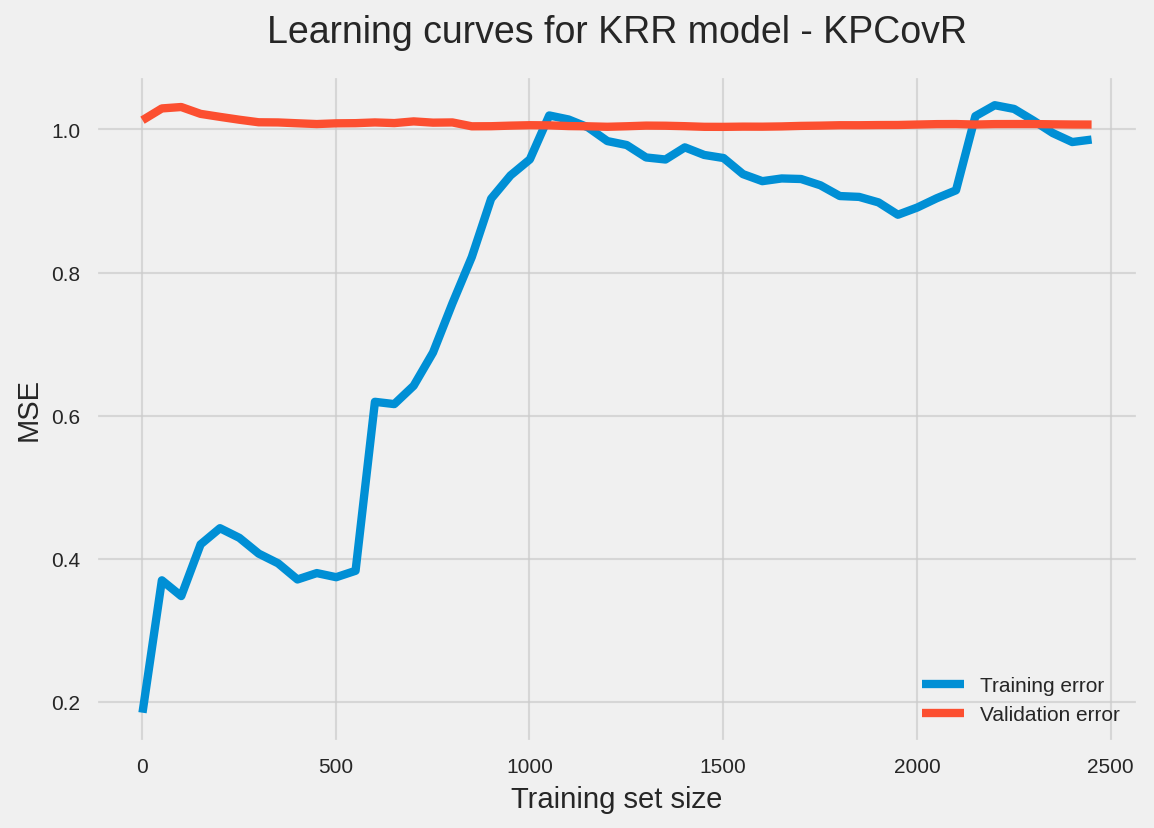

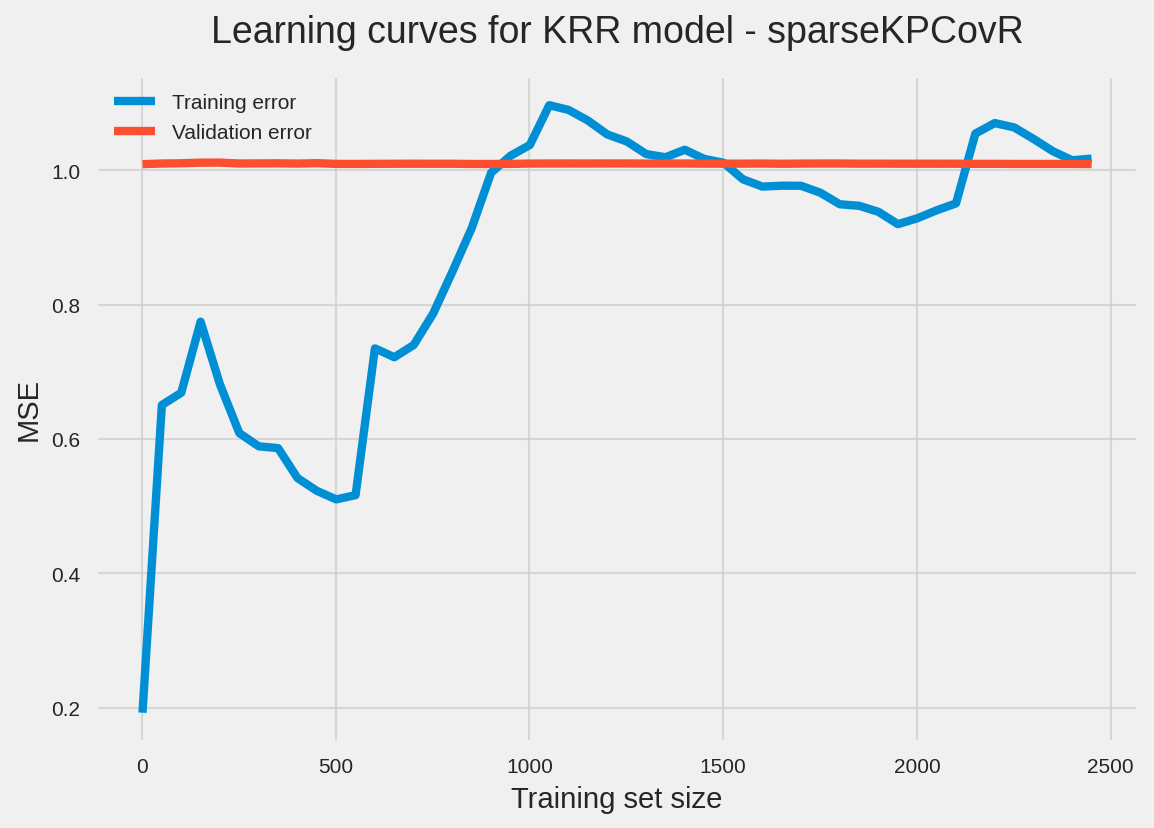

In [40]:

train_sizes, train_scores, validation_scores = learning_curve(estimator = KernelRidge(), X=t_tot, y=Y, 
                                                              train_sizes = train_sizes, cv = 5, scoring = 'neg_mean_squared_error')

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis =1 )
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for KRR model - KPCovR', fontsize = 18, y = 1.03)
plt.legend()
plt.show()
plt.close()

train_sizes, train_scores, validation_scores = learning_curve(estimator = KernelRidge(), X=T_skpcovr, y=Y, 
                                                              train_sizes = train_sizes, cv = 5, scoring = 'neg_mean_squared_error')

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis =1 )
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for KRR model - sparseKPCovR', fontsize = 18, y = 1.03)
plt.legend()
plt.show()
plt.close()


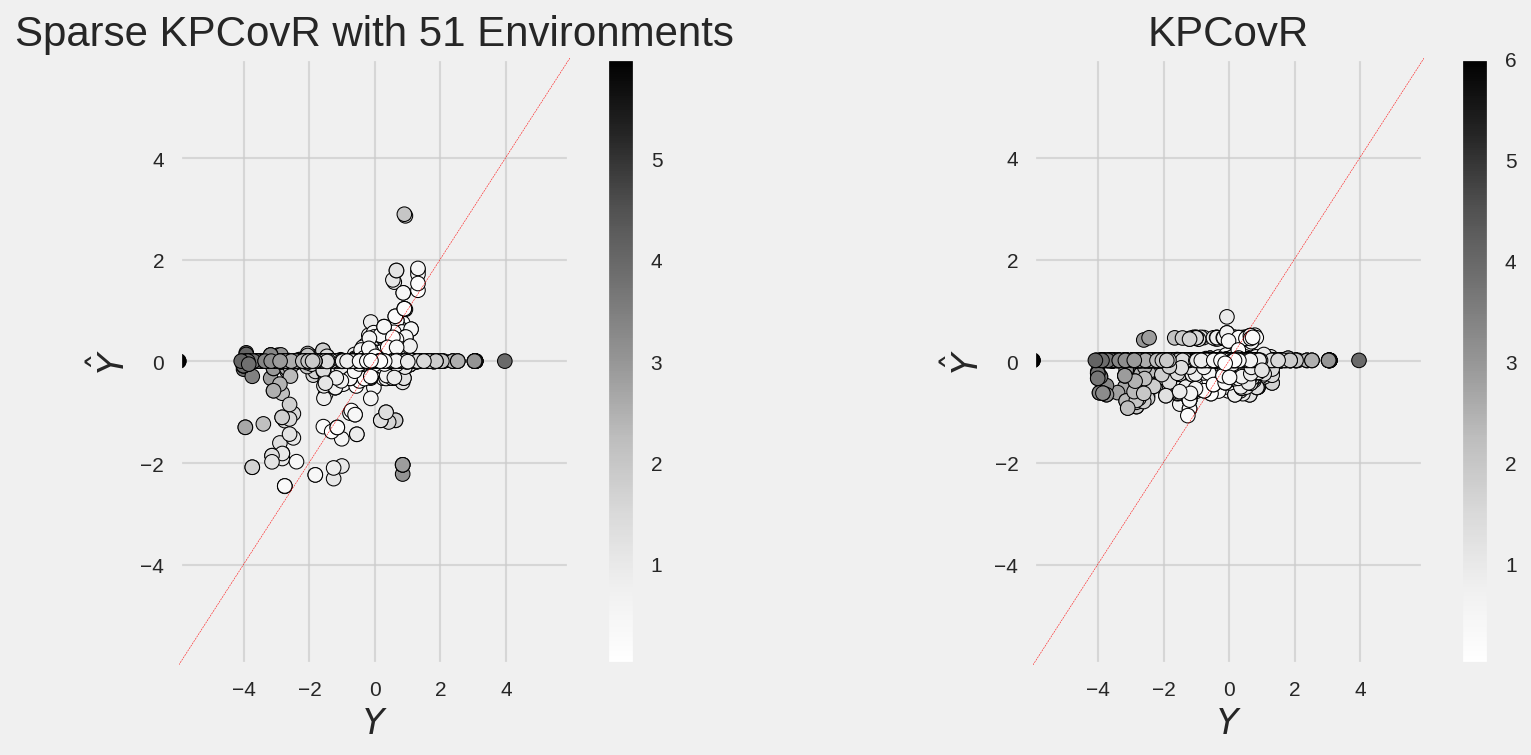

<center><b> Ridge Regression </b></center><br>                            <center><table><tr><th></th><th><center>KRR</center></th><th><center>sKRR</center></th></tr><td> Coefficient of Determination<br>($R^2$) </td>                                                <td> -0.000299927 </td><td> -1.41877 </td></tr><tr><td> $\ell_{regr}$ </td>                                                <td> 0.00205551 </td><td> 0.0021223 </td></tr></table></center>

In [41]:

PTY = T.T @ T
PTY = np.linalg.pinv(PTY) @ T.T @ Y_train

Ypred = Knm_test @ PKT @ PTY

fig, axes = plt.subplots(1, 2, figsize=dbl_fig)

plot_regression(
    Y_test[:, 0],
    Ypred[:, 0],
    fig=fig,
    ax=axes[0],
    title=f"Sparse KPCovR with {n_active} Environments",
    **cmaps,
)
plot_regression(Y_test[:, 0], y[:, 0], fig=fig, ax=axes[1], title="KPCovR", **cmaps)

plt.show()

table_from_dict(
    [
        get_stats(
            x=X_test,
            y=Ypred,
            yp=Y_krr,
        ),
        get_stats(
            x=X_test,
            y=y,
            yp=Y_skrr_test,
        ),
    ],
    headers=["KRR", "sKRR"],
    title="Ridge Regression",
)

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
print(t_tot,  Y)

[[-0.14111185 -0.01334668]
 [-0.14111185 -0.01334668]
 [-0.14111185 -0.01334668]
 ...
 [-0.14111185 -0.01334668]
 [-0.14111185 -0.01334668]
 [-0.14111185 -0.01334668]] [[-0.32050348]
 [-0.32050348]
 [-0.32050348]
 ...
 [-0.64323535]
 [-0.64323535]
 [-0.64323535]]


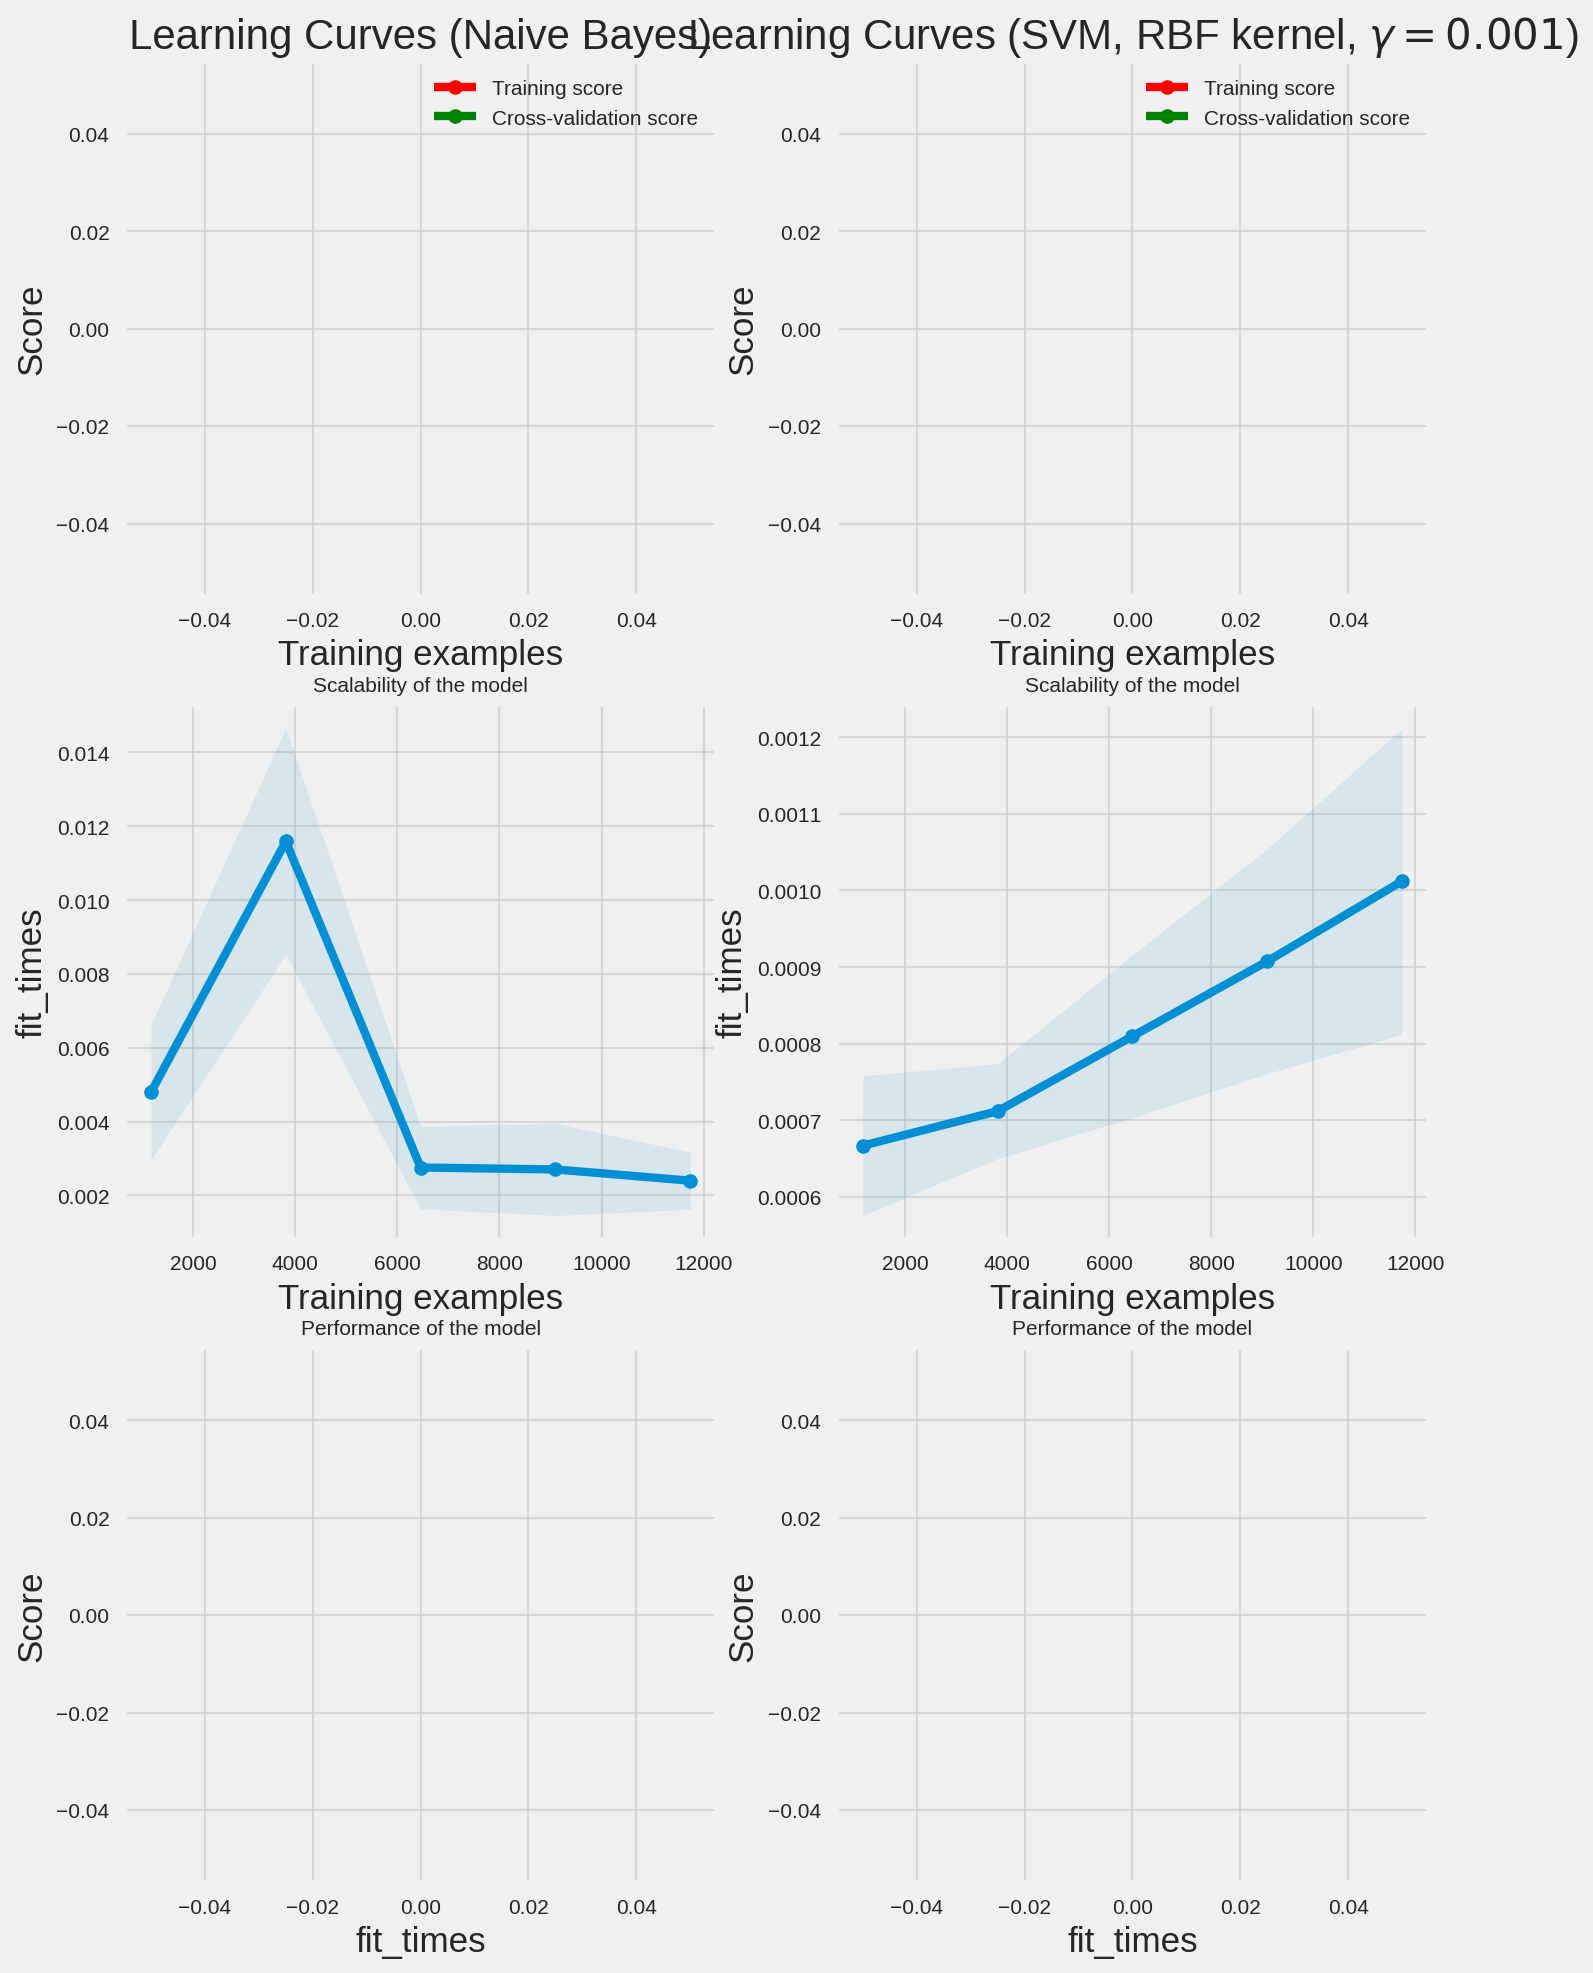

In [59]:

X=np.copy(t_tot)
y=np.copy(Y)

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
#     if ylim is not None:
#         axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
#     axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
#     axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model", fontsize=10)

    # Plot fit_time vs score
#     axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model", fontsize=10)

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))


title = "Learning Curves (Naive Bayes)"

# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], 
                    cv=5, n_jobs=4)

title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 1],
                    cv=5, n_jobs=4)

plt.show()

/home/egazzarrini/.local/lib/python3.8/site-packages/scikit_learn-0.24.1-py3.8-linux-x86_64.egg/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/egazzarrini/.local/lib/python3.8/site-packages/scikit_learn-0.24.1-py3.8-linux-x86_64.egg/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/egazzarrini/.local/lib/python3.8/site-packages/scikit_learn-0.24.1-py3.8-linux-x86_64.egg/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/egazzarrini/.local/lib/python3.8/site-packages/scikit_learn-0.24.1-py3.8-linux-x86_64.egg/sklearn/svm/_base.py", line 173, in fit
    y = self._va

/home/egazzarrini/.local/lib/python3.8/site-packages/scikit_learn-0.24.1-py3.8-linux-x86_64.egg/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/egazzarrini/.local/lib/python3.8/site-packages/scikit_learn-0.24.1-py3.8-linux-x86_64.egg/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/egazzarrini/.local/lib/python3.8/site-packages/scikit_learn-0.24.1-py3.8-linux-x86_64.egg/sklearn/svm/_base.py", line 173, in fit
    y = self._validate_targets(y)
  File "/home/egazzarrini/.local/lib/python3.8/site-packages/scikit_learn-0.24.1-py3.8-linux-x86_64.egg/sklearn/svm/_base.py", line 553, in _validate_targets
    check_classification_targets(y)
  File "/home/egazzarrini/.local/lib/python3.8/site-packages/scikit_learn-0.24.1-py3.8-linux-x86_64.

/home/egazzarrini/.local/lib/python3.8/site-packages/scikit_learn-0.24.1-py3.8-linux-x86_64.egg/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/egazzarrini/.local/lib/python3.8/site-packages/scikit_learn-0.24.1-py3.8-linux-x86_64.egg/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/egazzarrini/.local/lib/python3.8/site-packages/scikit_learn-0.24.1-py3.8-linux-x86_64.egg/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/egazzarrini/.local/lib/python3.8/site-packages/scikit_learn-0.24.1-py3.8-linux-x86_64.egg/sklearn/svm/_base.py", line 173, in fit
    y = self._va

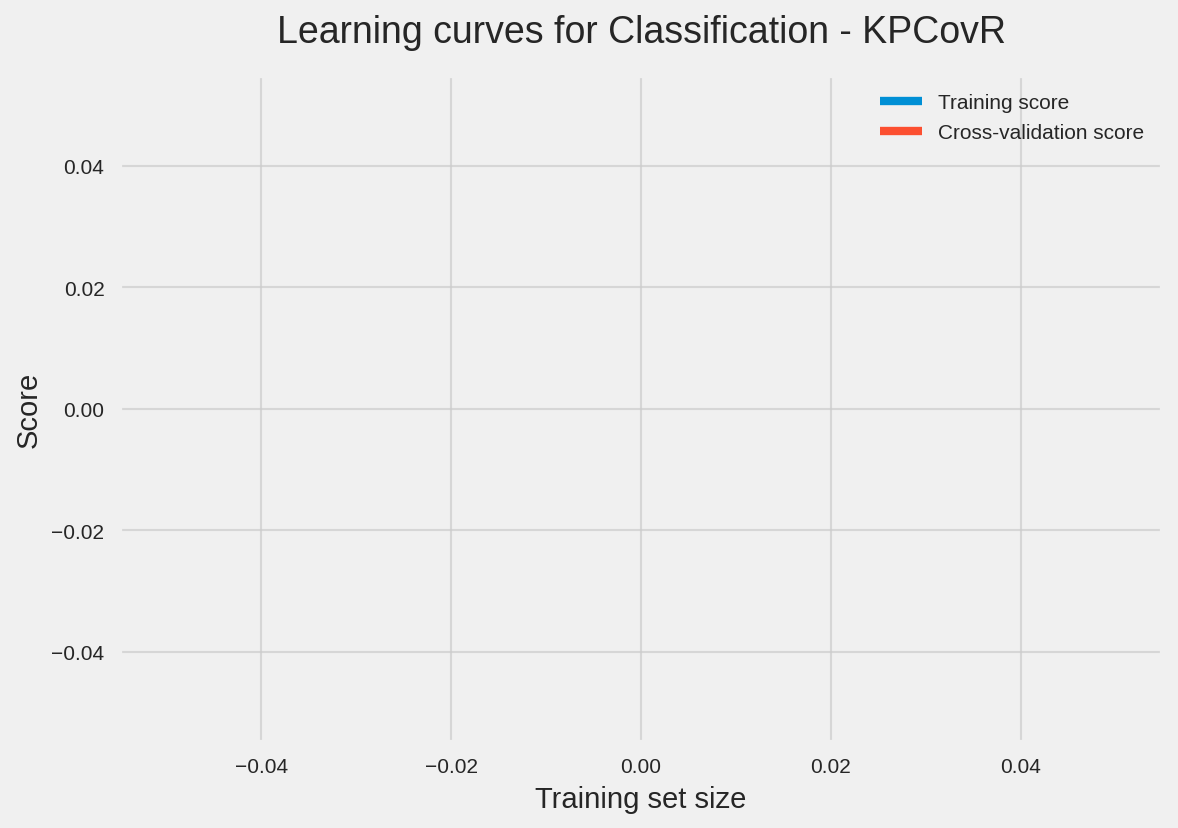

In [85]:

X=np.copy(t_tot)
y=np.copy(Y)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)

train_sizes, train_scores, test_scores = learning_curve(estimator = estimator, X=X, y=y, 
                                                              train_sizes = train_sizes, cv = cv, scoring = 'neg_mean_squared_error')


train_scores_mean = -train_scores.mean(axis = 1)

# test_scores_mean = -validation_scores.mean(axis =1 )


train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
# plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
#                  label="Training score")
# plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
#                  label="Cross-validation score")
# plt.legend(loc="best")

plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Cross-validation score')
plt.ylabel('Score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for Classification - KPCovR', fontsize = 18, y = 1.03)
plt.legend()
plt.show()
plt.close()


# train_sizes, train_scores, test_scores, fit_times, _ = \
#         learning_curve(estimator, X, y,
#                        train_sizes=train_sizes,
#                        return_times=True)

# train_scores_mean = -train_scores.mean(axis = 1)
# train_scores_std = np.std(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# test_scores_std = np.std(test_scores, axis=1)
# fit_times_mean = np.mean(fit_times, axis=1)
# fit_times_std = np.std(fit_times, axis=1)

# print(train_scores_mean)
# plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                          train_scores_mean + train_scores_std, alpha=0.1,
#                          color="r")
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                          test_scores_mean + test_scores_std, alpha=0.1,
#                          color="g")
# plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
#                  label="Training score")
# plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
#                  label="Cross-validation score")
# plt.legend(loc="best")

# plt.plot(train_sizes, train_scores_mean, label = 'Training error')

# plt.ylabel('MSE', fontsize = 14)
# plt.xlabel('Training set size', fontsize = 14)
# plt.title('Learning curves for KRR model - sparseKPCovR', fontsize = 18, y = 1.03)
# plt.legend()
# plt.show()
# plt.close()
# def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
#                         n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):


#     train_sizes, train_scores, test_scores, fit_times, _ = \
#         learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
#                        train_sizes=train_sizes,
#                        return_times=True)
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)
#     fit_times_mean = np.mean(fit_times, axis=1)
#     fit_times_std = np.std(fit_times, axis=1)
#     # Plot learning curve

#     plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                          train_scores_mean + train_scores_std, alpha=0.1,
#                          color="r")
#     plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                          test_scores_mean + test_scores_std, alpha=0.1,
#                          color="g")
#     plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
#                  label="Training score")
#     plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
#                  label="Cross-validation score")
#     plt.legend(loc="best")
#     return plt


# fig, axes = plt.subplots(1, 2, figsize=(9,8))


# title = "Learning Curves (Naive Bayes)"
# # Cross validation with 100 iterations to get smoother mean test and train
# # score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

# estimator = GaussianNB()
# plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
#                         n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))

# title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# # SVC is more expensive so we do a lower number of CV iterations:
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
# estimator = SVC(gamma=0.001)
# plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
#                         n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))
# plt.show()